In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.impute import SimpleImputer

from mpl_toolkits import mplot3d

In [27]:
pd.set_option('display.max_columns', None)
X = pd.read_csv('../../../data/trainingsetvalues.csv')
y = pd.read_csv('../../../data/trainingsetlabels.csv')

In [28]:
X.funder = X.funder.replace(np.nan, 'Unknown')
X.installer = X.installer.replace(np.nan, 'Unknown')
X.permit = X.permit.replace(np.nan, False)

In [29]:
y = y.drop(columns = 'id')

In [30]:
y.status_group.loc[y.status_group == 'functional'] = 1
y.status_group.loc[y.status_group != 1] = 0
y = y.astype(int)

In [31]:
droplist = ['wpt_name', 'subvillage', 'num_private', 'scheme_name', 'recorded_by', 'scheme_management', 'management', 'extraction_type', 
            'payment', 'extraction_type_class', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group', 'ward',
           'region_code', 'district_code', 'public_meeting', 'funder', 'lga', 'management_group']

X_clean = X.drop(columns = droplist, axis=1)

# Created a new age column

In [32]:
years = [int(X_clean['date_recorded'][x][:4]) for x in range(len(X_clean['date_recorded']))]
X_clean['date_recorded'] = years

In [33]:
X_clean.construction_year = X_clean.construction_year.replace(0, 2000)

In [34]:
X_clean['age'] = X_clean['date_recorded'] - X_clean['construction_year']

# Cleaned up the Installer Column

In [35]:
top_installers = list(X_clean.installer.value_counts()[:7].index)
top_installers

['DWE', 'Unknown', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT']

In [36]:
X_clean.installer.loc[~X_clean['installer'].isin(top_installers)] = 'Other'

# Filled in Zero's for the gps_height column

In [37]:
dodoma_idx = X_clean[X_clean.region == 'Dodoma'].index
X_clean.at[dodoma_idx, 'gps_height'] = 1350

In [38]:
kagera_idx = X_clean[X_clean.region == 'Kagera'].index
X_clean.at[kagera_idx, 'gps_height'] = 1450

In [39]:
mbeya_idx = X_clean[X_clean.region == 'Mbeya'].index
X_clean.at[mbeya_idx, 'gps_height'] = 1715

In [40]:
tabora_idx = X_clean[X_clean.region == 'Tabora'].index
X_clean.at[tabora_idx, 'gps_height'] = 1200

In [41]:
shinyanga_idx = X_clean[X_clean.region == 'Shinyanga'].index
X_clean.at[shinyanga_idx, 'gps_height'] = 1162

In [42]:
mwanza_idx = X_clean[X_clean.region == 'Mwanza'].index
X_clean.at[mwanza_idx, 'gps_height'] = 1200

# Made a function for returning catagorical and numerical columns

In [43]:
def cleaning(data):
    cat_cols = list(data.select_dtypes('object'))
    numeric_cols = list(data.select_dtypes('number'))
    cat_df = pd.DataFrame(data[cat_cols])
    numeric_df = pd.DataFrame(data[numeric_cols])
    return cat_df, numeric_df

# Split into categorical and numerical

In [46]:
X_cats, X_nums = cleaning(X_clean)
X_nums.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)

# One hot encoder and scaler

In [47]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_cats)
X_cats_ohe = pd.DataFrame(ohe.transform(X_cats), columns = ohe.get_feature_names(input_features = X_cats.columns))

In [48]:
ss = StandardScaler()
ss.fit(X_nums)
X_nums_scaled = pd.DataFrame(ss.transform(X_nums), columns = X_nums.columns)

In [49]:
X_data = pd.concat((X_nums_scaled, X_cats_ohe), axis=1)

In [77]:
X_data

,amount_tsh,date_recorded,gps_height,population,construction_year,age,installer_Commu,installer_DANIDA,installer_DWE,installer_Government,installer_KKKT,installer_Other,installer_RWE,installer_Unknown,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,extraction_type_group_afridev,extraction_type_group_gravity,extraction_type_group_india mark ii,extraction_type_group_india mark iii,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,1.895665,-0.961322,0.485487,-0.150399,0.105584,-0.194575,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.105970,1.124729,0.501776,0.212290,1.186187,-1.071715,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.097630,1.124729,-0.788697,0.148660,1.087950,-0.974255,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.105970,1.124729,-1.554293,-0.258570,-1.171491,1.267325,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.105970,-0.961322,0.594082,-0.381587,0.203821,-0.292035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Our class for testing data features on our model

In [107]:
class Model:
    
    def __init__(self, model, y):
        self.model = model
        self.y = np.array(y).ravel()
        self.columns = ['f1 score', 'accuracy_score', 'Notes']
        self.df = pd.DataFrame(columns = self.columns)
        
    def model_history(self, X, notes, y=None):
        if not y:
            y = self.y
        
        f1_score = cross_val_score(self.model, X, cv=3, scoring = 'f1', y=self.y)
        accuracy_score = cross_val_score(self.model, X, cv=3, scoring='accuracy', y=self.y)
        frame = pd.DataFrame([[f1_score.mean(), accuracy_score.mean(), notes]], columns=self.columns)
        self.df = self.df.append(frame).reset_index(drop=True)
#       self.df = self.df.sort_values('f1 score', ascending=False)
        return f1_score, accuracy_score

    def error_vis(self, X, y=None):
        if not y:
            y = self.y
        self.model.fit(X, self.y)
        sns.set(rc = {'figure.figsize':(10,6)})
        sns.distplot((np.array(y).ravel() - self.model.predict_proba(X)[:,1]),
            color='blue', bins=25, kde_kws = {'color':'red'})

# Our Model

In [108]:
rf_2 = RandomForestClassifier(max_depth = 18, min_samples_split = 15, n_estimators = 50)

## Base Model with no engineering

In [109]:
tester = Model(rf_2, y)

In [98]:
tester.model_history(X_data, notes='Base model with no feature engineering')

(array([0.82853944, 0.8301562 , 0.83003003]),
 array([0.80075758, 0.80247475, 0.80030303]))

In [105]:
tester.df

,f1 score,accuracy_score,Notes


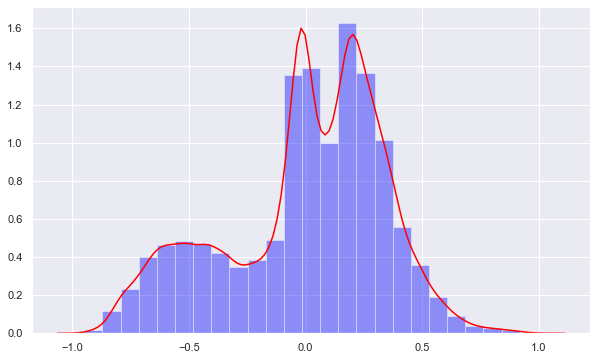

In [110]:
tester.error_vis(X_data)

# Finding Error and why it happens

In [808]:
error_df = pd.DataFrame()
error_df = pd.concat((pd.DataFrame(np.array(y_train).ravel()), pd.DataFrame(rf_2.predict_proba(X_train))), axis=1)
error_df['prediction'] = rf_2.predict(X_train)
error_df.columns = ['True Value', 'P: Broke', 'P: Works', 'Prediction']

In [809]:
error_df['Correct?'] = (error_df['Prediction'] == error_df['True Value'])
error_df['Percent Wrong'] = np.array(y_train).ravel() - rf_2.predict_proba(X_train)[:,1]
error_df['Percent Wrong'] = error_df['Percent Wrong'].map(abs)*100


## Creating New Dataframes of error

In [810]:
error_df = error_df.sort_values('Percent Wrong', ascending=False)

In [811]:
correct_guesses = error_df.loc[(error_df['Percent Wrong'] < 50)].sort_values('Percent Wrong', ascending=True)
incorrect_guesses = error_df.loc[(error_df['Percent Wrong'] >= 50)]

correct_indexes = correct_guesses.index
incorrect_indexes = incorrect_guesses.index

In [812]:
false_positives = error_df.loc[(error_df['Percent Wrong'] >= 50) & (error_df['Prediction'] == 1)]
false_negatives = error_df.loc[(error_df['Percent Wrong'] >= 50) & (error_df['Prediction'] == 0)]

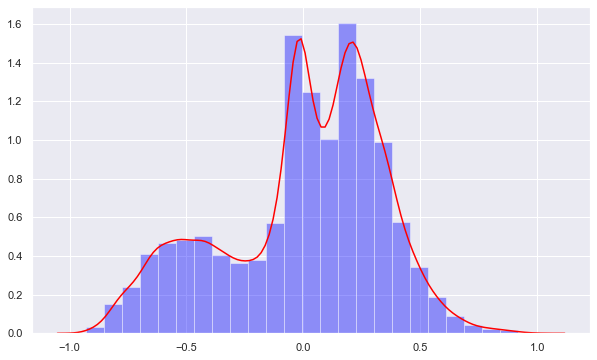

In [850]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.distplot((np.array(y_train).ravel() - rf_2.predict_proba(X_train)[:,1]),
            color='blue', bins=25, kde_kws = {'color':'red'});

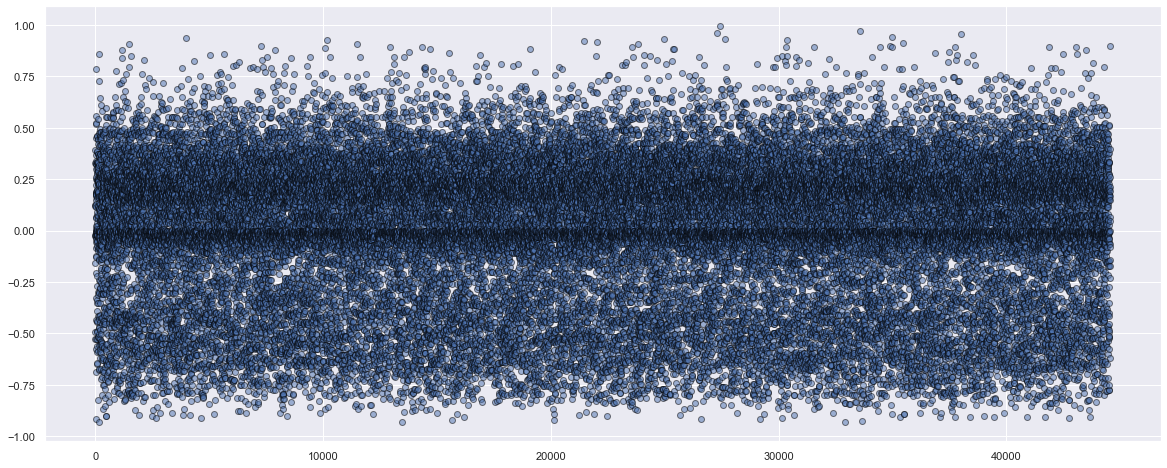

In [841]:
plt.figure(figsize=(20,8))
plt.scatter(list(range(len(y_train))), np.array(y_train).ravel() - rf_2.predict_proba(X_train)[:,1], alpha=.5, edgecolor='black' );

In [282]:
X_graph = X_clean.loc[X['longitude'] != 0]
#X_clean.loc[X_clean['gps_height'] == 0]['region'].value_counts()

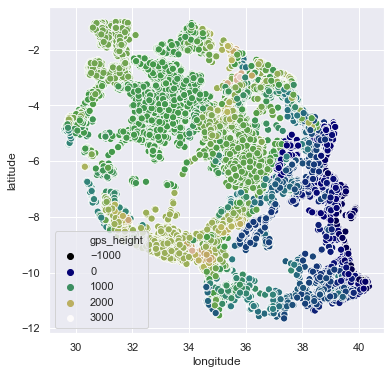

In [853]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data = X_graph, y = 'latitude', x = 'longitude', hue='gps_height', palette = 'gist_earth', s=50);

### Class Model

In [827]:
# class Model:
    
#     def __init__(self, model, X_val, y_val):
#         self.model = model
#         self.y = np.array(y).ravel()
#         self.columns = ['f1 score', 'accuracy_score', 'Notes']
#         self.df = pd.DataFrame(columns = self.columns)
#         self.X_val
        
#     def model_history(self, X_train, notes, model=None, y_train=None):
#         if not model:
#             model = self.model
#         if not y:
#             y = self.y
        
#         model.fit(X_train, y_train)
#         f1score = f1_score(y, model.predict(X_va))
#         accuracyscore = accuracy_score(y, model.predict(X))
#         frame = pd.DataFrame([[f1score, accuracyscore, notes]], columns=self.columns)
#         self.df = self.df.append(frame).reset_index(drop=True)
#         self.df = self.df.sort_values('f1 score', ascending=False)
#         return f1score, accuracyscore

In [56]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.distplot((np.array(y_train).ravel() - rf_2.predict_proba(X_train)[:,1]),
            color='blue', bins=25, kde_kws = {'color':'red'});

NameError: name 'y_train' is not defined